# Fried Eggs

- Labeling some of the images using CVAT.

# Labeling The images using YOLO(instance segmentation)

In [1]:
%%capture

!pip install ultralytics

## Preparing Data

In [2]:
src_path = "/kaggle/input/fried-eggs/Labeled-FriedEggs"
label_path = "/kaggle/working/Labeled_data"
Source_images_path = "/kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs"
Saving_path = "/kaggle/working"

In [3]:
import shutil, os

try:
    shutil.copytree(os.path.join(src_path, "labels"), os.path.join(label_path, "labels"), dirs_exist_ok=False)
except FileExistsError as e:
    print(e)

## Creating Yaml file

In [4]:
%%capture

!pip install pyyaml

In [5]:
import yaml, os

with open(os.path.join(src_path, 'data.yaml'), 'r') as file:
    data = yaml.safe_load(file)

data_yaml = f"""
path: {label_path}
train: images/train
val: images/train

nc: {len(data["names"])}
names: {list(data["names"].values())}
"""

yaml_path = os.path.join(label_path, 'data.yaml')
with open(yaml_path, "w") as f:
    f.write(data_yaml)

## Copying Images

In [6]:
import os, shutil

images_path = [os.path.join(f"{Source_images_path}/train", path.replace(".txt", ".jpg")) for path in os.listdir(os.path.join(label_path + "/labels/train"))]
dst_path = os.path.join(label_path, "images")
if not os.path.exists(dst_path):
    os.makedirs(dst_path, exist_ok=False)
    dst_path = os.path.join(dst_path, "train")
    os.makedirs(dst_path, exist_ok=False)
    for image_path in images_path:
        shutil.copy(image_path, dst_path)
if os.path.exists(os.path.join(label_path, 'train.txt')):
    os.remove(os.path.join(label_path, 'train.txt'))

In [7]:
import cv2
import os
import glob
import numpy as np

def hex_to_bgr(hex_color):
    """Convert hex color string to OpenCV BGR tuple."""
    hex_color = hex_color.lstrip("#")
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return rgb[::-1]

# Paths
image_dir = "/kaggle/working/Labeled_data/images/train"
label_dir = "/kaggle/working/Labeled_data/labels/train"  # YOLO segmentation .txt files
masks_dir = "/kaggle/working/Labeled_data/masks"
class_colors = ["#ddff33","#ff00cc","#3d3df5","#a0a0a0","#fa3253","#733380","#bffde2"]

os.makedirs(masks_dir, exist_ok=True)

# Get all images
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

for img_path in image_paths:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label__path = os.path.join(label_dir, base_name + ".txt")

    if not os.path.exists(label__path):
        print(f"Label not found for {img_path}")
        continue

    with open(label__path, "r") as f:
        lines = f.readlines()

    # Prepare a transparent mask
    mask = np.zeros(img.shape, dtype=np.uint8)

    for line in lines:
        parts = line.strip().split()
        cls_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Denormalize and reshape into Nx1x2 for cv2.fillPoly
        points = np.array([
            [int(float(x) * w), int(float(y) * h)]
            for x, y in zip(coords[::2], coords[1::2])
        ], dtype=np.int32).reshape((-1, 1, 2))

        color = class_colors[cls_id]
        cv2.fillPoly(mask, [points], hex_to_bgr(color))

    # Blend original with mask
    masked_img = cv2.addWeighted(img, 1.0, mask, 0.5, 0)

    # Save result
    cv2.imwrite(os.path.join(masks_dir, base_name + "_masked.jpg"), masked_img)

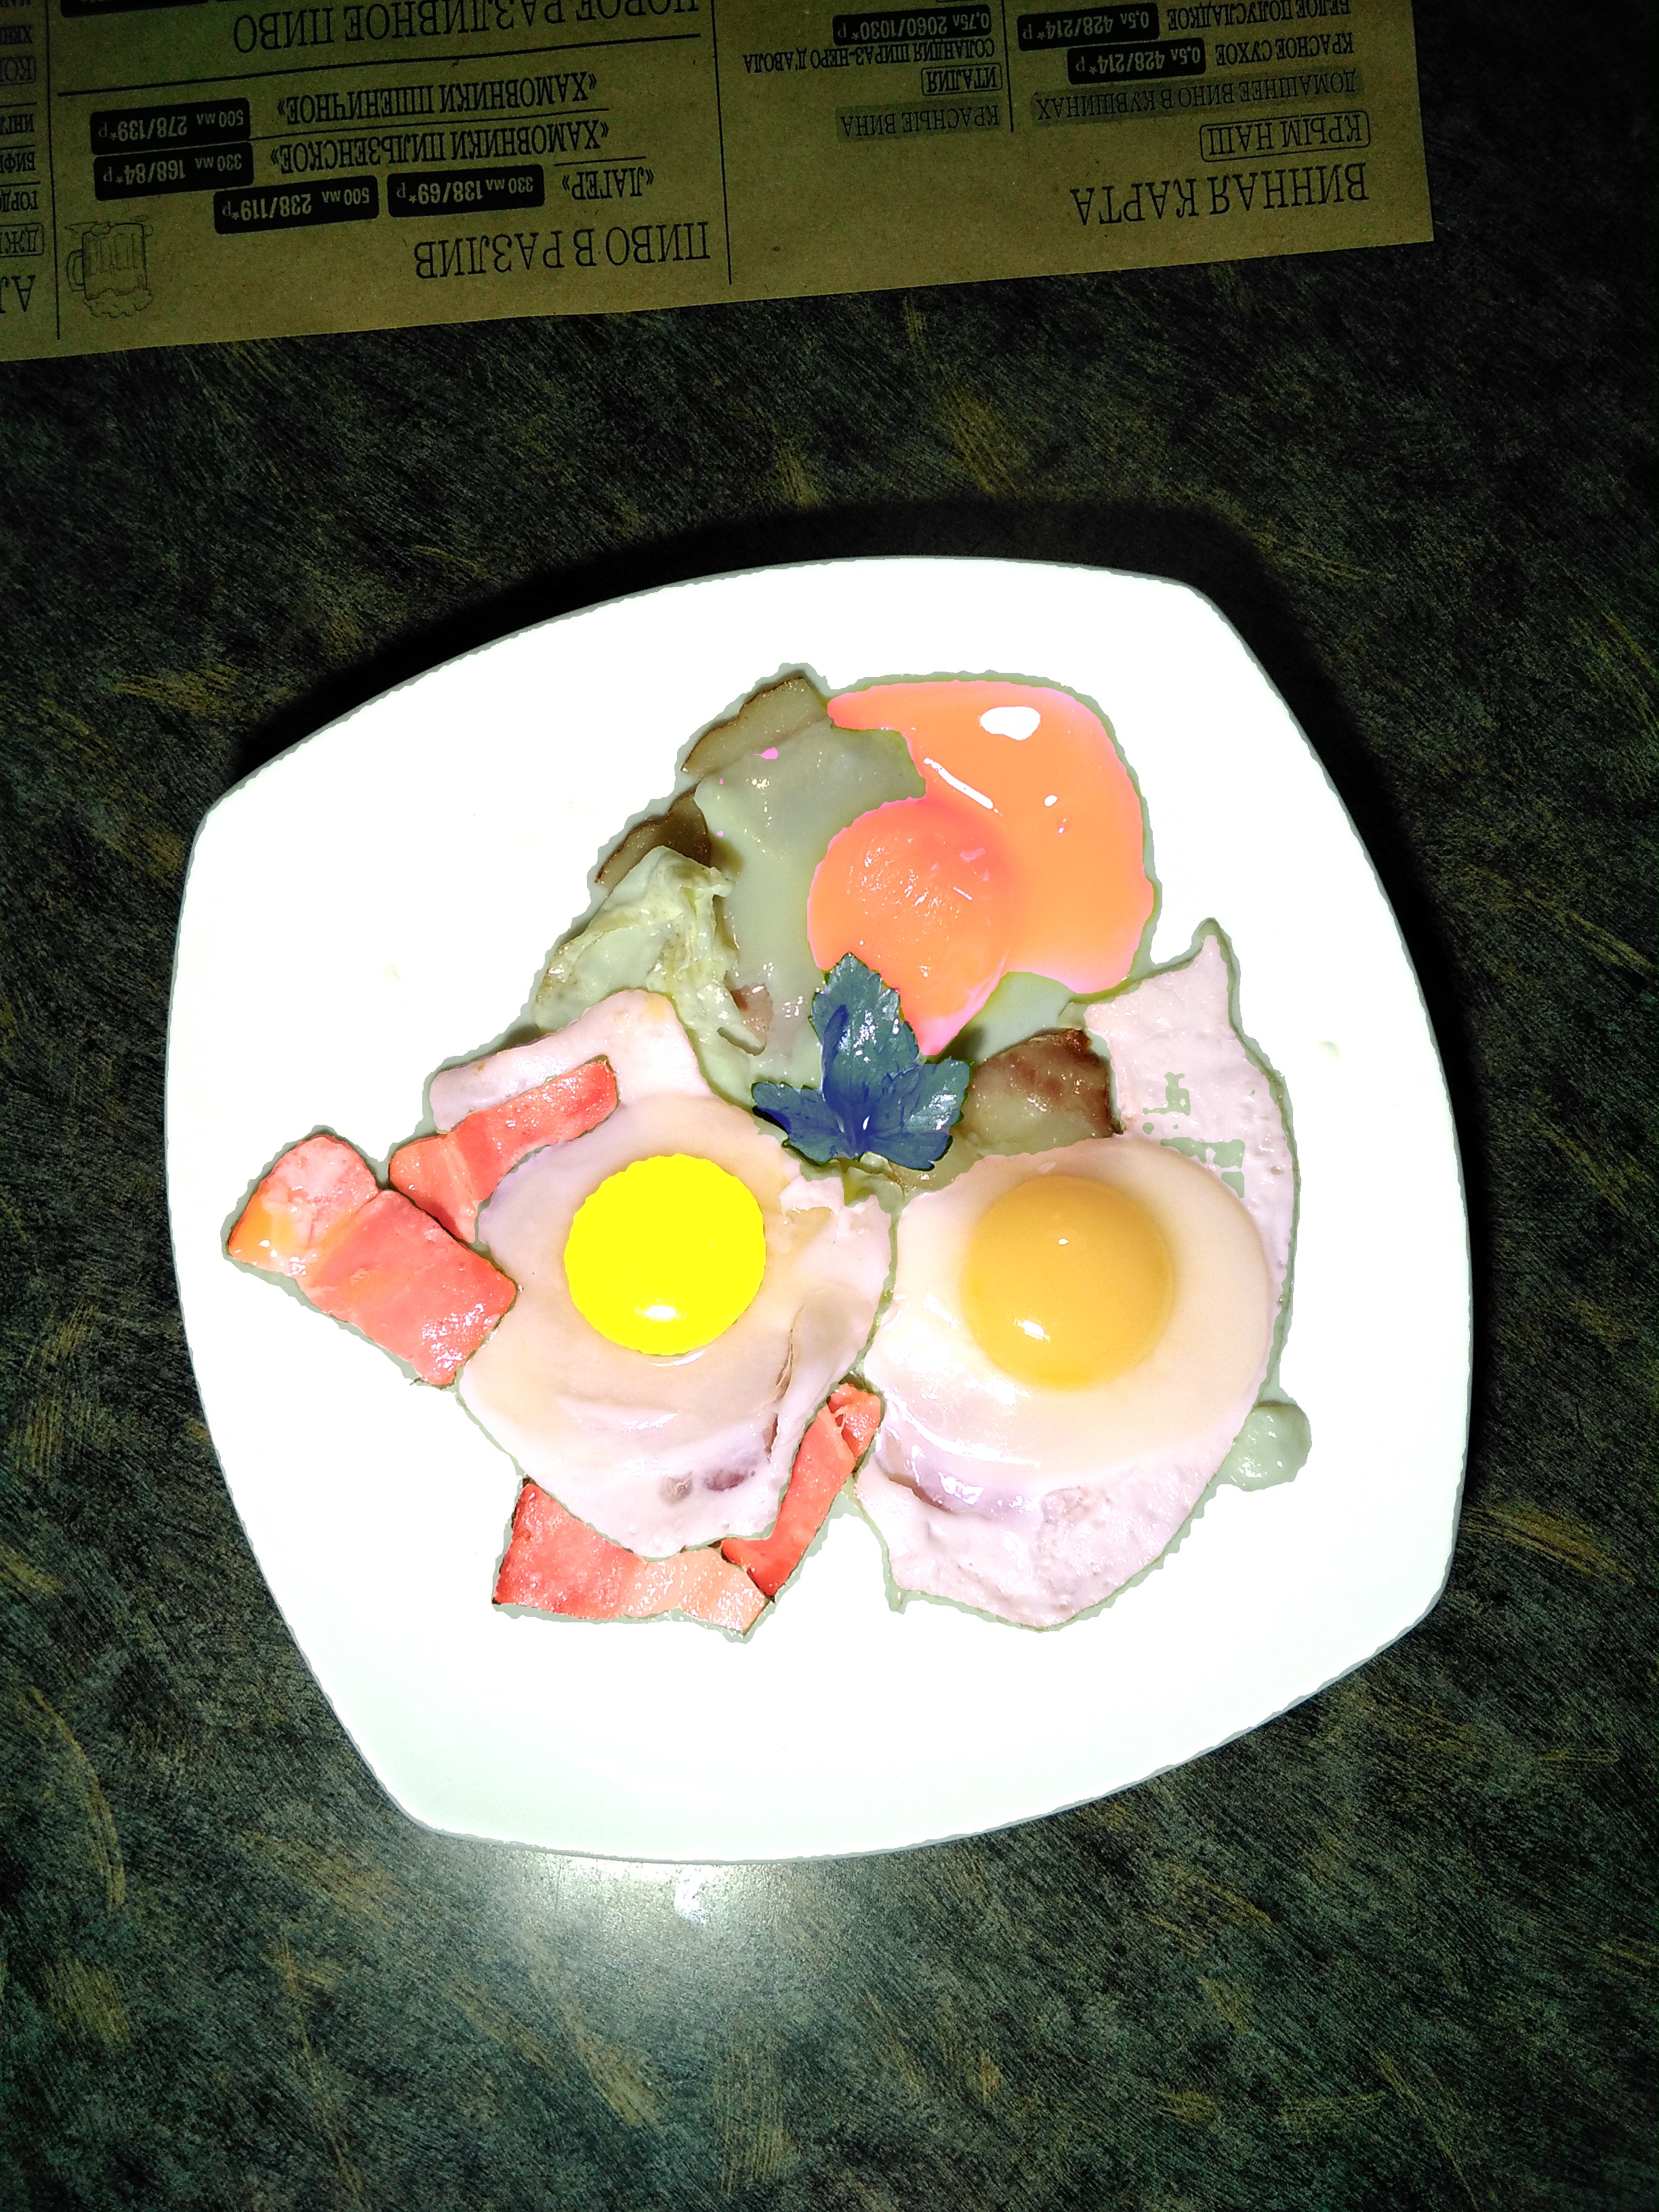

In [8]:
import glob
from IPython.display import Image, display

masks_dir = "/kaggle/working/Labeled_data/masks"
predicted_imgs = glob.glob(f"{masks_dir}/*.jpg")
display(Image(filename=predicted_imgs[1]))


# Traing the Yolo model 

In [9]:
from ultralytics import YOLO
import os

model_path = os.path.join(Saving_path, "runs/segment/train/weights/best.pt")
if os.path.exists(model_path):
    model = YOLO(model_path)
else:
    model = YOLO('yolo11n-seg.pt')

    model.train(
        data= yaml_path,
        epochs=300,
        imgsz=640,
        device=0
    )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.90M/5.90M [00:00<00:00, 71.1MB/s]


Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Labeled_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

100%|██████████| 755k/755k [00:00<00:00, 18.5MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3086.0±617.3 MB/s, size: 1719.1 KB)


train: Scanning /kaggle/working/Labeled_data/labels/train... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 201.28it/s]

train: New cache created: /kaggle/working/Labeled_data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1774.6±1985.6 MB/s, size: 1794.0 KB)


val: Scanning /kaggle/working/Labeled_data/labels/train.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/300       2.8G      1.129      2.964      3.949      1.254        286        640: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         13        211    0.00691     0.0878      0.014    0.00509    0.00416     0.0489    0.00313    0.00119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/300       2.8G      1.123      3.082      3.973      1.236        273        640: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         13        211    0.00776      0.108     0.0114    0.00456    0.00512     0.0546    0.00374    0.00143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/300       2.8G      1.123      3.112      3.965      1.333        223        640: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         13        211    0.00743      0.102     0.0155    0.00494    0.00457     0.0482    0.00351    0.00124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/300       2.8G      1.141       3.15      4.001      1.282        311        640: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         13        211    0.00857     0.0996      0.012    0.00423    0.00536     0.0461     0.0038    0.00122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/300       2.8G      1.151      3.129      3.994      1.268        240        640: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         13        211    0.00942     0.0975     0.0144    0.00453    0.00578     0.0439    0.00472    0.00114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/300       2.8G      1.151      3.076      3.987      1.272        305        640: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         13        211     0.0125      0.107     0.0147    0.00683    0.00852     0.0657    0.00697     0.0024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.82G      1.022      2.849      3.971      1.184        290        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         13        211     0.0188      0.132     0.0169    0.00989     0.0141     0.0756    0.00981    0.00445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.82G      1.005      2.547      3.916      1.151        311        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         13        211      0.019       0.13     0.0209     0.0113     0.0162      0.125     0.0131    0.00475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.82G     0.9837      2.466      3.855      1.113        324        640: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         13        211      0.025      0.136     0.0283     0.0169     0.0175      0.111     0.0175    0.00867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.82G     0.8503      2.162      3.749      1.087        262        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         13        211     0.0224      0.148     0.0307     0.0194     0.0187      0.123     0.0203     0.0102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.82G     0.8725       2.02      3.699      1.097        255        640: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         13        211     0.0355      0.169     0.0447     0.0261      0.031      0.138     0.0298     0.0156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.82G     0.8744      1.759       3.76      1.071        295        640: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         13        211     0.0353      0.221      0.049     0.0306     0.0346      0.189     0.0388     0.0208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.82G     0.8625       1.84      3.734      1.062        323        640: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         13        211     0.0354      0.212     0.0546     0.0317      0.033      0.198     0.0413     0.0212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.82G     0.8734      1.827      3.749      1.063        273        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211     0.0358      0.212      0.062     0.0373     0.0358      0.212      0.054     0.0271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.82G     0.8038      1.343      3.545      1.055        254        640: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         13        211     0.0348      0.216     0.0963     0.0679     0.0348      0.216     0.0921     0.0501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.86G     0.8907      1.655      3.769      1.027        370        640: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         13        211     0.0334      0.241      0.118     0.0873     0.0332       0.22      0.118     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.86G     0.8266      1.413      3.563      1.003        282        640: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         13        211     0.0322      0.263      0.139      0.101      0.032      0.243      0.132     0.0678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.86G     0.7892      1.468      3.382      1.006        265        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         13        211     0.0322      0.263      0.139      0.101      0.032      0.243      0.132     0.0678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.87G     0.7821      1.489      3.282      1.024        204        640: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         13        211     0.0333      0.267       0.13     0.0987     0.0325      0.222      0.126     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.87G     0.7688      1.278       3.43     0.9725        302        640: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         13        211     0.0333      0.267       0.13     0.0987     0.0325      0.222      0.126     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.87G     0.8072      1.294      3.416     0.9757        313        640: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         13        211     0.0308      0.267      0.137      0.103     0.0306      0.247      0.129     0.0718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.87G     0.8026        1.3      3.345     0.9957        286        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         13        211     0.0308      0.267      0.137      0.103     0.0306      0.247      0.129     0.0718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.87G     0.7892      1.301      3.346     0.9788        274        640: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         13        211     0.0296      0.271      0.122      0.086     0.0293      0.251      0.102     0.0584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.87G     0.7156      1.136      3.139      0.989        264        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         13        211     0.0296      0.271      0.122      0.086     0.0293      0.251      0.102     0.0584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.87G     0.7391      1.209      3.226     0.9628        272        640: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         13        211     0.0242      0.276      0.131     0.0942      0.024       0.27      0.119     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.87G     0.6831      1.192      3.062     0.9604        241        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         13        211     0.0242      0.276      0.131     0.0942      0.024       0.27      0.119     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.87G      0.698      1.086      3.005     0.9733        207        640: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         13        211     0.0241       0.28      0.148      0.115     0.0241       0.28      0.141     0.0851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.87G     0.8167      1.184      3.099      0.977        266        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         13        211     0.0241       0.28      0.148      0.115     0.0241       0.28      0.141     0.0851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.87G       0.77      1.141      3.004     0.9874        235        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         13        211     0.0217      0.276      0.154      0.122     0.0217      0.276      0.145     0.0927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.87G     0.6827      1.162      2.904     0.9637        218        640: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         13        211     0.0217      0.276      0.154      0.122     0.0217      0.276      0.145     0.0927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.87G     0.7243      1.069      2.887       0.99        256        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         13        211      0.022       0.28      0.153      0.123     0.0224      0.284      0.148     0.0968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.87G     0.7833      1.165      2.837     0.9795        239        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         13        211      0.022       0.28      0.153      0.123     0.0224      0.284      0.148     0.0968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.87G     0.6821      0.972      2.741     0.9778        206        640: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         13        211     0.0204      0.271      0.152      0.121     0.0204      0.271      0.152     0.0982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.87G     0.8053      1.159      2.966     0.9539        339        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         13        211     0.0204      0.271      0.152      0.121     0.0204      0.271      0.152     0.0982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.87G     0.6901     0.9821      2.761     0.9638        233        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         13        211       0.02      0.276      0.152      0.125       0.02      0.276       0.15      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.87G     0.7079     0.9474      2.652     0.9548        242        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         13        211       0.02      0.276      0.152      0.125       0.02      0.276       0.15      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.87G     0.7454      1.172      2.784     0.9459        270        640: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         13        211     0.0199      0.281      0.162      0.126     0.0199      0.281      0.162      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.87G     0.7217     0.9849      2.588     0.9657        270        640: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         13        211     0.0199      0.281      0.162      0.126     0.0199      0.281      0.162      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.87G     0.7936      1.132      2.859     0.9363        358        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         13        211     0.0209      0.313      0.182      0.141     0.0209      0.313      0.182      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.87G      0.736      1.027      2.489     0.9652        219        640: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         13        211     0.0209      0.313      0.182      0.141     0.0209      0.313      0.182      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.87G     0.8409      1.151      2.609     0.9892        273        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         13        211     0.0209      0.316      0.206      0.165     0.0209      0.316      0.206      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.87G      0.757      1.044      2.348     0.9571        242        640: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         13        211     0.0209      0.316      0.206      0.165     0.0209      0.316      0.206      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.87G     0.7462      1.078      2.395     0.9699        253        640: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         13        211     0.0224      0.374      0.238      0.203     0.0224      0.374      0.238       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.87G     0.7589     0.9797      2.272     0.9614        261        640: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211     0.0224      0.374      0.238      0.203     0.0224      0.374      0.238       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.87G     0.7483      1.098      2.395      0.933        285        640: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         13        211     0.0228      0.388      0.285      0.245     0.0228      0.388      0.285      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.87G     0.6803     0.9079      2.176     0.9212        241        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         13        211     0.0228      0.388      0.285      0.245     0.0228      0.388      0.285      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.87G      0.705      1.028       2.22     0.9245        252        640: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         13        211     0.0245      0.406      0.307      0.267     0.0245      0.406      0.307      0.256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.87G     0.7808     0.9861      2.163     0.9368        245        640: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         13        211     0.0245      0.406      0.307      0.267     0.0245      0.406      0.307      0.256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.87G     0.6711     0.8902      2.048     0.9175        219        640: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         13        211     0.0276      0.455      0.323      0.278      0.028      0.459      0.323      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.87G      0.668     0.9148      2.065     0.9198        278        640: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         13        211     0.0276      0.455      0.323      0.278      0.028      0.459      0.323      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.87G     0.7105     0.8299      1.928      0.954        223        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13        211     0.0319      0.517      0.372       0.33     0.0322      0.521      0.372      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.87G       0.68     0.8743      1.976     0.9214        291        640: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         13        211     0.0319      0.517      0.372       0.33     0.0322      0.521      0.372      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.87G     0.6951     0.8048      1.961     0.9147        270        640: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         13        211     0.0319      0.517      0.372       0.33     0.0322      0.521      0.372      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.87G     0.6545     0.7879      1.854     0.9089        225        640: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         13        211     0.0352      0.583      0.451      0.397     0.0355      0.587      0.454      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.87G     0.7209     0.9358      1.784     0.9234        238        640: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         13        211     0.0352      0.583      0.451      0.397     0.0355      0.587      0.454      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.87G     0.7406      1.008       1.91     0.9213        292        640: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


                   all         13        211     0.0352      0.583      0.451      0.397     0.0355      0.587      0.454      0.391

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.87G     0.7605      1.033      2.094     0.9498        354        640: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         13        211     0.0359      0.601      0.511      0.437     0.0362      0.605      0.515       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.87G     0.6876     0.9548      1.717     0.9198        254        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         13        211     0.0359      0.601      0.511      0.437     0.0362      0.605      0.515       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.87G     0.7242     0.8578      1.776      0.919        286        640: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         13        211     0.0359      0.601      0.511      0.437     0.0362      0.605      0.515       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.87G     0.7272      1.019      1.809     0.9359        260        640: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         13        211     0.0361      0.624      0.561      0.475     0.0364      0.628      0.569      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.87G      0.648     0.8254      1.673     0.9327        235        640: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         13        211     0.0361      0.624      0.561      0.475     0.0364      0.628      0.569      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.87G     0.7108     0.9273      1.678     0.9018        221        640: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         13        211     0.0361      0.624      0.561      0.475     0.0364      0.628      0.569      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.87G     0.6457     0.7989        1.5     0.9349        209        640: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         13        211     0.0364      0.628      0.583      0.502     0.0364      0.628       0.58      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.87G     0.6998     0.8119      1.543     0.8981        287        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         13        211     0.0364      0.628      0.583      0.502     0.0364      0.628       0.58      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.87G     0.6702     0.8296      1.605     0.8918        298        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         13        211     0.0364      0.628      0.583      0.502     0.0364      0.628       0.58      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.87G     0.6519     0.7777      1.494     0.8839        283        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         13        211      0.036      0.628        0.6      0.515      0.036      0.628      0.597      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.87G     0.6232     0.8069      1.284     0.9139        201        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         13        211      0.036      0.628        0.6      0.515      0.036      0.628      0.597      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.87G     0.6665     0.7819      1.305     0.9061        229        640: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         13        211      0.036      0.628        0.6      0.515      0.036      0.628      0.597      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.87G     0.6493     0.7351      1.469     0.9403        225        640: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         13        211      0.814       0.52      0.603      0.519      0.839        0.5      0.596      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.87G     0.6779     0.8827      1.463     0.9136        280        640: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         13        211      0.814       0.52      0.603      0.519      0.839        0.5      0.596      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.87G     0.7343      0.877      1.397     0.9334        202        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         13        211      0.814       0.52      0.603      0.519      0.839        0.5      0.596      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.87G     0.6925     0.9081      1.402     0.8983        302        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         13        211      0.968      0.185      0.603      0.512      0.968      0.185      0.603      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.87G     0.6496     0.8151      1.312     0.8932        280        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         13        211      0.968      0.185      0.603      0.512      0.968      0.185      0.603      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.87G     0.6771     0.8156      1.353     0.9196        166        640: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         13        211      0.968      0.185      0.603      0.512      0.968      0.185      0.603      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.87G     0.6399     0.7962       1.27     0.8679        246        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         13        211      0.989      0.121      0.617      0.529      0.989      0.121      0.614      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.87G     0.6241     0.7648        1.2     0.8991        237        640: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211      0.989      0.121      0.617      0.529      0.989      0.121      0.614      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.87G     0.7126     0.8346      1.273     0.9204        259        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         13        211      0.989      0.121      0.617      0.529      0.989      0.121      0.614      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.87G     0.6399     0.7606      1.139     0.8862        249        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         13        211      0.984      0.186      0.633      0.554      0.984      0.186       0.63      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.87G     0.6355     0.7902      1.181     0.8922        224        640: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         13        211      0.984      0.186      0.633      0.554      0.984      0.186       0.63      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.87G     0.6377     0.7639      1.126     0.8858        259        640: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         13        211      0.984      0.186      0.633      0.554      0.984      0.186       0.63      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.87G     0.6287     0.8405      1.185     0.8808        277        640: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         13        211      0.968      0.334      0.633      0.548      0.968      0.334      0.633      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.87G     0.6503     0.7809      1.215       0.89        298        640: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         13        211      0.968      0.334      0.633      0.548      0.968      0.334      0.633      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.87G     0.6303     0.7896      1.201     0.9014        299        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         13        211      0.968      0.334      0.633      0.548      0.968      0.334      0.633      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.87G     0.6696     0.7456      1.142     0.9076        244        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         13        211      0.956      0.418      0.632      0.553      0.962      0.422      0.636      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.87G     0.6547     0.7676      1.162     0.9237        248        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         13        211      0.956      0.418      0.632      0.553      0.962      0.422      0.636      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.87G     0.6421     0.7909      1.086     0.8782        263        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         13        211      0.956      0.418      0.632      0.553      0.962      0.422      0.636      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.87G     0.6336     0.7601      1.123     0.8669        299        640: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         13        211      0.956      0.418      0.632      0.553      0.962      0.422      0.636      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.87G     0.6256      0.841      1.103     0.8708        266        640: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         13        211      0.942      0.441      0.636      0.572      0.942      0.441      0.636      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.87G     0.6428     0.7856      1.154     0.8804        263        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211      0.942      0.441      0.636      0.572      0.942      0.441      0.636      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.87G     0.5891      0.693      1.013     0.8772        278        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         13        211      0.942      0.441      0.636      0.572      0.942      0.441      0.636      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.87G     0.6016     0.7567      1.006     0.8877        254        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         13        211      0.942      0.441      0.636      0.572      0.942      0.441      0.636      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.87G     0.6427     0.7731      1.098     0.8758        342        640: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         13        211      0.931      0.446      0.633      0.569      0.931      0.446      0.633      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.87G     0.5923     0.7478      1.013     0.8771        268        640: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         13        211      0.931      0.446      0.633      0.569      0.931      0.446      0.633      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.87G      0.621     0.8105      1.051     0.8764        268        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         13        211      0.931      0.446      0.633      0.569      0.931      0.446      0.633      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.87G      0.602     0.7498      1.037     0.8879        310        640: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         13        211      0.931      0.446      0.633      0.569      0.931      0.446      0.633      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.87G     0.5576      0.756     0.9675     0.8771        274        640: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         13        211      0.933      0.469      0.632      0.569      0.933      0.469      0.632      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.87G     0.5834      0.789     0.9473     0.8806        291        640: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         13        211      0.933      0.469      0.632      0.569      0.933      0.469      0.632      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.87G     0.5932     0.7464      1.032     0.8783        264        640: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13        211      0.933      0.469      0.632      0.569      0.933      0.469      0.632      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.87G     0.5742     0.7936     0.9745     0.8959        248        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         13        211      0.933      0.469      0.632      0.569      0.933      0.469      0.632      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.87G     0.5688     0.6896     0.9699     0.8781        294        640: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         13        211      0.925      0.463       0.63       0.58      0.925      0.463       0.63       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.87G     0.5597     0.6536     0.9744     0.8993        194        640: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         13        211      0.925      0.463       0.63       0.58      0.925      0.463       0.63       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.87G     0.6094     0.8642     0.9745     0.8797        299        640: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         13        211      0.925      0.463       0.63       0.58      0.925      0.463       0.63       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.87G     0.5571     0.6366     0.9311     0.8631        292        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         13        211      0.925      0.463       0.63       0.58      0.925      0.463       0.63       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.87G       0.53     0.6208     0.9439     0.8878        243        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         13        211      0.919      0.493       0.63      0.576      0.919      0.493       0.63      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.87G      0.536     0.6227     0.8976     0.8654        255        640: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         13        211      0.919      0.493       0.63      0.576      0.919      0.493       0.63      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.87G     0.5317      0.622      0.918     0.8755        233        640: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         13        211      0.919      0.493       0.63      0.576      0.919      0.493       0.63      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.87G     0.6099     0.7546     0.9449     0.8763        265        640: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         13        211      0.919      0.493       0.63      0.576      0.919      0.493       0.63      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.87G     0.5718     0.6771     0.9132     0.9004        255        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         13        211      0.902      0.516      0.629      0.574      0.902      0.516      0.629      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.87G     0.6214     0.8694     0.9516     0.9056        217        640: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         13        211      0.902      0.516      0.629      0.574      0.902      0.516      0.629      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.87G     0.6531     0.8962      1.003     0.8976        291        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         13        211      0.902      0.516      0.629      0.574      0.902      0.516      0.629      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.87G     0.5851     0.8194      0.925     0.8633        250        640: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         13        211      0.902      0.516      0.629      0.574      0.902      0.516      0.629      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.87G     0.5663     0.6865     0.9752     0.9104        253        640: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         13        211      0.911      0.569      0.639      0.581      0.911      0.569      0.639      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.87G     0.5387     0.6567      0.884     0.8719        279        640: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         13        211      0.911      0.569      0.639      0.581      0.911      0.569      0.639      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.87G     0.5074     0.6161     0.8497      0.856        260        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13        211      0.911      0.569      0.639      0.581      0.911      0.569      0.639      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.87G     0.5829     0.7478     0.9209     0.8831        280        640: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13        211      0.911      0.569      0.639      0.581      0.911      0.569      0.639      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.87G     0.5535      0.708     0.8528     0.8891        271        640: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         13        211      0.906      0.603       0.64      0.589      0.906      0.603       0.64      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.87G     0.5369     0.6678     0.8574     0.8493        280        640: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         13        211      0.906      0.603       0.64      0.589      0.906      0.603       0.64      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.87G     0.5433     0.7232     0.8642     0.8713        285        640: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         13        211      0.906      0.603       0.64      0.589      0.906      0.603       0.64      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.87G     0.5144     0.7708     0.8239     0.8832        236        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         13        211      0.906      0.603       0.64      0.589      0.906      0.603       0.64      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.87G      0.522     0.6601     0.8412     0.8806        210        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         13        211      0.929       0.62      0.642      0.592      0.929       0.62      0.642       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.87G     0.5426     0.6694     0.8111     0.8724        254        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         13        211      0.929       0.62      0.642      0.592      0.929       0.62      0.642       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.87G     0.5433     0.7102     0.8727     0.8634        291        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         13        211      0.929       0.62      0.642      0.592      0.929       0.62      0.642       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.87G     0.5371     0.7128     0.8726     0.8923        260        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         13        211      0.929       0.62      0.642      0.592      0.929       0.62      0.642       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.87G     0.5467     0.7767     0.9032     0.8862        247        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         13        211      0.931      0.623      0.643      0.605      0.931      0.623      0.643      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.87G     0.6111     0.6938     0.9212     0.8792        305        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         13        211      0.931      0.623      0.643      0.605      0.931      0.623      0.643      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.87G      0.511     0.6267     0.8408     0.8635        273        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         13        211      0.931      0.623      0.643      0.605      0.931      0.623      0.643      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.87G     0.5174     0.7475     0.8221     0.8429        322        640: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         13        211      0.931      0.623      0.643      0.605      0.931      0.623      0.643      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.87G     0.5431     0.7382     0.8425       0.87        285        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         13        211      0.955      0.622      0.644      0.597      0.955      0.622      0.644      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.87G     0.4873     0.6109     0.8119     0.8735        200        640: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211      0.955      0.622      0.644      0.597      0.955      0.622      0.644      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.87G     0.5514     0.7419     0.8551     0.8801        319        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         13        211      0.955      0.622      0.644      0.597      0.955      0.622      0.644      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.87G     0.4919     0.6618     0.8308     0.8556        349        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         13        211      0.955      0.622      0.644      0.597      0.955      0.622      0.644      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.87G     0.5195     0.6255     0.8348     0.8709        304        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         13        211      0.956      0.623      0.644      0.602      0.956      0.623      0.644      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.87G     0.4659     0.6107       0.79     0.8565        271        640: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         13        211      0.956      0.623      0.644      0.602      0.956      0.623      0.644      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.87G     0.5149     0.6382     0.8287     0.8508        293        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         13        211      0.956      0.623      0.644      0.602      0.956      0.623      0.644      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.87G     0.5478     0.6873     0.8076     0.8724        264        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         13        211      0.956      0.623      0.644      0.602      0.956      0.623      0.644      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.87G     0.4997       0.61     0.8457     0.8789        217        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         13        211      0.946      0.627      0.645      0.595      0.946      0.627      0.645       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.87G     0.4521     0.5063     0.7611     0.8837        213        640: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         13        211      0.946      0.627      0.645      0.595      0.946      0.627      0.645       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.87G     0.4576      0.594     0.7548     0.8562        242        640: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         13        211      0.946      0.627      0.645      0.595      0.946      0.627      0.645       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.87G     0.5032     0.6427     0.7592      0.854        303        640: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         13        211      0.946      0.627      0.645      0.595      0.946      0.627      0.645       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.87G     0.4694     0.5996     0.7649     0.8382        343        640: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         13        211       0.95      0.625      0.645      0.602       0.95      0.625      0.645      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.87G     0.4759     0.5683      0.731     0.8458        281        640: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         13        211       0.95      0.625      0.645      0.602       0.95      0.625      0.645      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.87G     0.5346     0.7268     0.8061     0.8621        305        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         13        211       0.95      0.625      0.645      0.602       0.95      0.625      0.645      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.87G     0.5205     0.6586     0.7864     0.8516        292        640: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         13        211       0.95      0.625      0.645      0.602       0.95      0.625      0.645      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.87G     0.4819     0.6895     0.7623     0.8873        219        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         13        211      0.945      0.625      0.646      0.613      0.945      0.625      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.87G     0.4641     0.6012     0.6948     0.8543        247        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         13        211      0.945      0.625      0.646      0.613      0.945      0.625      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.87G     0.4836     0.5876     0.7777     0.8659        269        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         13        211      0.945      0.625      0.646      0.613      0.945      0.625      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.87G     0.5176     0.6638     0.7636     0.8813        280        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         13        211      0.945      0.625      0.646      0.613      0.945      0.625      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.87G     0.4832     0.6106     0.7696     0.8393        312        640: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         13        211      0.939      0.628      0.647      0.599      0.939      0.628      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.87G     0.4913     0.7426     0.7954     0.8467        269        640: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         13        211      0.939      0.628      0.647      0.599      0.939      0.628      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.87G     0.4597      0.609     0.7288      0.853        280        640: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         13        211      0.939      0.628      0.647      0.599      0.939      0.628      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.87G     0.4664     0.6377     0.7518     0.8475        256        640: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         13        211      0.939      0.628      0.647      0.599      0.939      0.628      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.87G      0.483     0.6125     0.7565       0.87        273        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         13        211      0.937      0.636      0.647      0.599      0.937      0.636      0.647      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.87G     0.5293     0.7028       0.81     0.8624        225        640: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


                   all         13        211      0.937      0.636      0.647      0.599      0.937      0.636      0.647      0.579

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.87G     0.5306     0.7116     0.7984     0.8666        284        640: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         13        211      0.937      0.636      0.647      0.599      0.937      0.636      0.647      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.87G      0.517     0.7752      0.784     0.8893        288        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         13        211      0.937      0.636      0.647      0.599      0.937      0.636      0.647      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.87G     0.5587     0.8461      0.813     0.8613        295        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13        211      0.964       0.62      0.648      0.597      0.964       0.62      0.648      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.87G     0.5055     0.7316     0.7425     0.8705        314        640: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         13        211      0.964       0.62      0.648      0.597      0.964       0.62      0.648      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.87G     0.4751     0.7083     0.7687     0.8824        189        640: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         13        211      0.964       0.62      0.648      0.597      0.964       0.62      0.648      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.87G      0.482     0.6497     0.7098     0.8711        262        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         13        211      0.964       0.62      0.648      0.597      0.964       0.62      0.648      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.87G     0.4548      0.615     0.6776     0.8484        252        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all         13        211      0.971      0.616      0.649      0.599      0.971      0.616      0.649      0.581

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.87G     0.4794      0.613     0.7311     0.8504        219        640: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         13        211      0.971      0.616      0.649      0.599      0.971      0.616      0.649      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.87G     0.4468     0.6005     0.7257     0.8524        245        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         13        211      0.971      0.616      0.649      0.599      0.971      0.616      0.649      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.87G     0.4218     0.5686     0.6773      0.838        206        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         13        211      0.971      0.616      0.649      0.599      0.971      0.616      0.649      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.87G     0.4408     0.5684     0.6758     0.8522        264        640: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         13        211      0.957      0.628      0.648      0.614      0.957      0.628      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.87G     0.4686     0.6284     0.7092     0.8553        313        640: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         13        211      0.957      0.628      0.648      0.614      0.957      0.628      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.87G     0.4448     0.6238      0.719     0.8552        329        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         13        211      0.957      0.628      0.648      0.614      0.957      0.628      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.87G     0.4658     0.6413     0.7337       0.84        320        640: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         13        211      0.957      0.628      0.648      0.614      0.957      0.628      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.87G     0.4158     0.5795     0.6775      0.824        301        640: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         13        211      0.962      0.626      0.647       0.61      0.962      0.626      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.87G     0.5017     0.6253     0.7358     0.8541        330        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         13        211      0.962      0.626      0.647       0.61      0.962      0.626      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.87G     0.4738     0.6081     0.7102     0.8649        259        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         13        211      0.962      0.626      0.647       0.61      0.962      0.626      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.87G     0.4434     0.5422     0.6712     0.8498        251        640: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         13        211      0.962      0.626      0.647       0.61      0.962      0.626      0.647      0.587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.87G     0.5233     0.7995     0.7027     0.8797        238        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         13        211      0.973      0.621      0.646      0.609      0.973      0.621      0.646      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.87G     0.4395     0.5785     0.6912     0.8316        329        640: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         13        211      0.973      0.621      0.646      0.609      0.973      0.621      0.646      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.87G     0.4366     0.5839     0.6447     0.8281        245        640: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         13        211      0.973      0.621      0.646      0.609      0.973      0.621      0.646      0.581

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.87G     0.4731     0.6063     0.7054     0.8394        275        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         13        211      0.973      0.621      0.646      0.609      0.973      0.621      0.646      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.87G     0.4702     0.6148     0.6973     0.8446        264        640: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         13        211      0.972      0.621      0.646      0.604      0.972      0.621      0.646      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.87G     0.4522     0.5555     0.7177     0.8752        295        640: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         13        211      0.972      0.621      0.646      0.604      0.972      0.621      0.646      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.87G     0.4809     0.5939     0.7086     0.8466        278        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         13        211      0.972      0.621      0.646      0.604      0.972      0.621      0.646      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.87G     0.4606     0.6206     0.7111     0.8527        324        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         13        211      0.972      0.621      0.646      0.604      0.972      0.621      0.646      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.87G     0.4938     0.6579     0.7189     0.8443        276        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         13        211      0.968      0.632      0.645      0.607      0.968      0.632      0.645      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.87G      0.468     0.7107      0.697     0.8394        277        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         13        211      0.968      0.632      0.645      0.607      0.968      0.632      0.645      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.87G     0.4582     0.6115     0.7039     0.8483        239        640: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         13        211      0.968      0.632      0.645      0.607      0.968      0.632      0.645      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.87G     0.4979     0.6772     0.7669     0.9054        184        640: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         13        211      0.968      0.632      0.645      0.607      0.968      0.632      0.645      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.87G      0.432     0.5163     0.6645     0.8546        215        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         13        211      0.974      0.631      0.646      0.614      0.974      0.631      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.87G     0.4281     0.5565     0.6501     0.8467        269        640: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         13        211      0.974      0.631      0.646      0.614      0.974      0.631      0.646      0.583

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.87G     0.4085     0.5021     0.6479     0.8472        268        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         13        211      0.974      0.631      0.646      0.614      0.974      0.631      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.87G     0.4409     0.5114     0.6895      0.863        316        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13        211      0.974      0.631      0.646      0.614      0.974      0.631      0.646      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.87G       0.41     0.5561     0.6535     0.8406        188        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13        211      0.979      0.625      0.646      0.628      0.979      0.625      0.646       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.87G     0.4645     0.5981     0.7087     0.8524        340        640: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         13        211      0.979      0.625      0.646      0.628      0.979      0.625      0.646       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.87G     0.4269     0.5203     0.6571     0.8448        279        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         13        211      0.979      0.625      0.646      0.628      0.979      0.625      0.646       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.87G     0.4949     0.6464      0.711     0.8754        311        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         13        211      0.979      0.625      0.646      0.628      0.979      0.625      0.646       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.87G     0.4761      0.655     0.6891     0.8393        270        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         13        211      0.979      0.625      0.646      0.621      0.979      0.625      0.646      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.87G      0.435      0.526      0.627     0.8479        247        640: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         13        211      0.979      0.625      0.646      0.621      0.979      0.625      0.646      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.87G     0.4736     0.6412     0.6879     0.8526        292        640: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         13        211      0.979      0.625      0.646      0.621      0.979      0.625      0.646      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.87G     0.4266     0.5714     0.6265     0.8557        254        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         13        211      0.979      0.625      0.646      0.621      0.979      0.625      0.646      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.87G     0.4915     0.6491     0.7042     0.8581        312        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


                   all         13        211      0.968      0.636      0.647      0.624      0.968      0.636      0.647      0.585

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.87G       0.44     0.5222     0.6593     0.8343        313        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         13        211      0.968      0.636      0.647      0.624      0.968      0.636      0.647      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.87G     0.4165     0.4994     0.6427     0.8477        211        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         13        211      0.968      0.636      0.647      0.624      0.968      0.636      0.647      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.87G     0.4327     0.4989     0.6145     0.8382        266        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         13        211      0.968      0.636      0.647      0.624      0.968      0.636      0.647      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.87G     0.3927      0.484     0.6125     0.8416        225        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         13        211      0.976      0.632      0.648       0.62      0.976      0.632      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.87G     0.4338     0.5985     0.6536     0.8401        313        640: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         13        211      0.976      0.632      0.648       0.62      0.976      0.632      0.648      0.591

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.87G     0.4371     0.5657     0.6258     0.8289        230        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         13        211      0.976      0.632      0.648       0.62      0.976      0.632      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.87G     0.4409      0.625     0.6189     0.8392        285        640: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         13        211      0.976      0.632      0.648       0.62      0.976      0.632      0.648      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.87G     0.4047     0.5152      0.602     0.8418        197        640: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         13        211      0.979      0.632      0.649      0.615      0.979      0.632      0.649      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.87G     0.3981     0.5501     0.6416     0.8659        200        640: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         13        211      0.979      0.632      0.649      0.615      0.979      0.632      0.649      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.87G     0.4249     0.6039     0.6283      0.828        307        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         13        211      0.979      0.632      0.649      0.615      0.979      0.632      0.649      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.87G     0.3919     0.5433     0.5937     0.8351        228        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         13        211      0.979      0.632      0.649      0.615      0.979      0.632      0.649      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.87G     0.4617     0.6278      0.706     0.8581        331        640: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         13        211      0.982      0.635       0.65      0.623      0.982      0.635       0.65      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.87G     0.4301     0.5473     0.6747     0.8531        259        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         13        211      0.982      0.635       0.65      0.623      0.982      0.635       0.65      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.87G     0.3865      0.525     0.6023     0.8348        246        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13        211      0.982      0.635       0.65      0.623      0.982      0.635       0.65      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.87G     0.4303     0.6511     0.6414      0.818        259        640: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         13        211      0.982      0.635       0.65      0.623      0.982      0.635       0.65      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.87G     0.4147     0.6166      0.639      0.844        294        640: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         13        211      0.984      0.637       0.65      0.629      0.984      0.637       0.65      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.87G     0.3878      0.519     0.6103     0.8321        277        640: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         13        211      0.984      0.637       0.65      0.629      0.984      0.637       0.65      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.87G     0.3924      0.516     0.6029     0.8282        268        640: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         13        211      0.984      0.637       0.65      0.629      0.984      0.637       0.65      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.87G     0.4017     0.6308     0.6222     0.8523        174        640: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         13        211      0.984      0.637       0.65      0.629      0.984      0.637       0.65      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.87G     0.3855      0.552     0.5887      0.828        259        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         13        211      0.986      0.636      0.651      0.629      0.986      0.636      0.651      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.87G     0.3924     0.4435     0.5983     0.8507        222        640: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         13        211      0.986      0.636      0.651      0.629      0.986      0.636      0.651      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.87G     0.4185      0.587     0.6324     0.8619        251        640: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         13        211      0.986      0.636      0.651      0.629      0.986      0.636      0.651      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.87G      0.384     0.4529     0.6108     0.8658        201        640: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         13        211      0.986      0.636      0.651      0.629      0.986      0.636      0.651      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.87G     0.4177     0.5501     0.6289     0.8274        296        640: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         13        211      0.987      0.637      0.651      0.629      0.987      0.637      0.651      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.87G     0.4234     0.6132      0.615     0.8494        238        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         13        211      0.987      0.637      0.651      0.629      0.987      0.637      0.651      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.87G     0.3889      0.577     0.5693     0.8295        269        640: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         13        211      0.987      0.637      0.651      0.629      0.987      0.637      0.651      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.87G     0.4504     0.6394     0.6277     0.8319        264        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         13        211      0.987      0.637      0.651      0.629      0.987      0.637      0.651      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.87G     0.4276     0.6423     0.6331     0.8509        253        640: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         13        211      0.985      0.637      0.652      0.629      0.985      0.637      0.652      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.87G     0.4111     0.5731     0.5961     0.8296        249        640: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         13        211      0.985      0.637      0.652      0.629      0.985      0.637      0.652      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.87G     0.4322     0.6125     0.6213       0.83        292        640: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         13        211      0.985      0.637      0.652      0.629      0.985      0.637      0.652      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.87G      0.421     0.5955     0.6609     0.8257        367        640: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         13        211      0.985      0.637      0.652      0.629      0.985      0.637      0.652      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.87G     0.4312     0.5394     0.6001     0.8211        270        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         13        211      0.978      0.637      0.652      0.635      0.978      0.637      0.652        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.87G     0.3758     0.5687     0.5983     0.8428        287        640: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         13        211      0.978      0.637      0.652      0.635      0.978      0.637      0.652        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.87G     0.4112       0.54     0.6288     0.8371        344        640: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         13        211      0.978      0.637      0.652      0.635      0.978      0.637      0.652        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.87G     0.4017     0.6035     0.5981     0.8322        308        640: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         13        211      0.978      0.637      0.652      0.635      0.978      0.637      0.652        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.87G     0.3676      0.503     0.5857     0.8383        258        640: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         13        211      0.977      0.637      0.653      0.636      0.977      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.87G     0.3936     0.5812     0.5994     0.8244        255        640: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         13        211      0.977      0.637      0.653      0.636      0.977      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.87G     0.4016     0.5268     0.6003     0.8455        272        640: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         13        211      0.977      0.637      0.653      0.636      0.977      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.87G     0.3812     0.5101     0.5917     0.8477        232        640: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         13        211      0.977      0.637      0.653      0.636      0.977      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.87G     0.3883     0.6167     0.5912     0.8361        281        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211      0.977      0.637      0.653      0.641      0.977      0.637      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.87G     0.3922     0.5158     0.6031      0.842        256        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         13        211      0.977      0.637      0.653      0.641      0.977      0.637      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.87G     0.4158     0.5828     0.6281     0.8468        298        640: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         13        211      0.977      0.637      0.653      0.641      0.977      0.637      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.87G     0.3843     0.5271     0.5802     0.8508        277        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         13        211      0.977      0.637      0.653      0.641      0.977      0.637      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.87G     0.3673     0.4763      0.575     0.8256        291        640: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         13        211      0.988      0.635      0.653      0.642      0.988      0.635      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.87G     0.4025     0.5497     0.5842     0.8314        293        640: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         13        211      0.988      0.635      0.653      0.642      0.988      0.635      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.87G      0.403     0.5884     0.5799     0.8409        291        640: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         13        211      0.988      0.635      0.653      0.642      0.988      0.635      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.87G     0.4088     0.5828     0.5752     0.8445        294        640: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         13        211      0.988      0.635      0.653      0.642      0.988      0.635      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.87G     0.4001     0.5682     0.5986     0.8352        311        640: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         13        211      0.988      0.638      0.653      0.636      0.988      0.638      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.87G     0.3511     0.5248     0.5374      0.806        275        640: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         13        211      0.988      0.638      0.653      0.636      0.988      0.638      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.87G     0.4455     0.5469     0.6015     0.8434        278        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         13        211      0.988      0.638      0.653      0.636      0.988      0.638      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.87G     0.3966     0.5111     0.6239     0.8543        211        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         13        211      0.988      0.638      0.653      0.636      0.988      0.638      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.87G     0.3972     0.4829     0.5862     0.8397        228        640: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         13        211      0.988      0.637      0.653      0.634      0.988      0.637      0.653      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.87G     0.3667     0.5355     0.5649     0.8281        316        640: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         13        211      0.988      0.637      0.653      0.634      0.988      0.637      0.653      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.87G     0.3576     0.5112     0.5414     0.8421        262        640: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         13        211      0.988      0.637      0.653      0.634      0.988      0.637      0.653      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.87G     0.3779     0.5548     0.5702     0.8229        319        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         13        211      0.988      0.637      0.653      0.634      0.988      0.637      0.653      0.597

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.87G     0.3684     0.5103     0.5913     0.8474        294        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         13        211      0.987      0.637      0.653      0.634      0.987      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.87G     0.4002     0.5681     0.6117     0.8282        201        640: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         13        211      0.987      0.637      0.653      0.634      0.987      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.87G     0.3892      0.525     0.5823     0.8076        331        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         13        211      0.987      0.637      0.653      0.634      0.987      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.87G      0.366     0.5246     0.5836     0.8546        226        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         13        211      0.987      0.637      0.653      0.634      0.987      0.637      0.653      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.87G     0.3765     0.5024      0.595       0.84        319        640: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         13        211      0.991      0.639      0.653      0.635      0.991      0.639      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.87G     0.3958     0.5027      0.586     0.8299        303        640: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         13        211      0.991      0.639      0.653      0.635      0.991      0.639      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.87G     0.3797     0.4681     0.5645     0.8384        295        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         13        211      0.991      0.639      0.653      0.635      0.991      0.639      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.87G     0.3545      0.495     0.5752     0.8412        226        640: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         13        211      0.991      0.639      0.653      0.635      0.991      0.639      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.87G     0.3783     0.5377     0.5517     0.8304        273        640: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         13        211      0.991      0.639      0.653       0.64      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.87G     0.3634     0.4615     0.5873     0.8374        220        640: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         13        211      0.991      0.639      0.653       0.64      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.87G     0.3625     0.4901     0.5458     0.8364        267        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         13        211      0.991      0.639      0.653       0.64      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.87G     0.3723     0.4991     0.5792      0.851        255        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         13        211      0.991      0.639      0.653       0.64      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.87G     0.3634       0.48     0.5591     0.8485        202        640: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         13        211      0.991      0.639      0.653      0.641      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.87G     0.3629     0.5397     0.5524     0.8306        276        640: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         13        211      0.991      0.639      0.653      0.641      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.87G     0.3828      0.564     0.5777     0.8307        326        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         13        211      0.991      0.639      0.653      0.641      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    267/300      2.87G     0.3397     0.4604     0.5291     0.8196        234        640: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         13        211      0.991      0.639      0.653      0.641      0.991      0.639      0.653      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    268/300      2.87G     0.3556     0.4585     0.5599      0.833        270        640: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    269/300      2.87G     0.3628     0.4491       0.55     0.8361        254        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    270/300      2.87G     0.3568     0.5086     0.5461     0.8539        250        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    271/300      2.87G     0.3743     0.5102     0.5746      0.837        315        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    272/300      2.87G     0.3678      0.535     0.5498     0.8366        274        640: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         13        211       0.99      0.639      0.653      0.644       0.99      0.639      0.653      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    273/300      2.87G     0.3637     0.4958     0.5707      0.832        267        640: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         13        211       0.99      0.639      0.653      0.644       0.99      0.639      0.653      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    274/300      2.87G     0.3393     0.4857     0.5465     0.8321        307        640: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         13        211       0.99      0.639      0.653      0.644       0.99      0.639      0.653      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    275/300      2.87G     0.3609     0.4936     0.5648       0.83        269        640: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         13        211       0.99      0.639      0.653      0.644       0.99      0.639      0.653      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    276/300      2.87G     0.3635     0.4817     0.5769     0.8632        221        640: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    277/300      2.87G     0.3874       0.57     0.6407     0.8272        375        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    278/300      2.87G     0.3757     0.4991      0.556     0.8273        298        640: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    279/300      2.87G     0.3828     0.5457     0.5624     0.8337        275        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         13        211       0.99      0.639      0.653      0.643       0.99      0.639      0.653      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    280/300      2.87G     0.3749     0.5796     0.5634     0.8198        260        640: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    281/300      2.87G     0.3599     0.5391     0.5743     0.8451        250        640: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    282/300      2.87G     0.3588     0.4683     0.5458     0.8354        248        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    283/300      2.87G     0.3513     0.5308     0.5643      0.848        239        640: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    284/300      2.87G     0.3661      0.554     0.5971     0.8184        369        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         13        211       0.99      0.639      0.654      0.646       0.99      0.639      0.654      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    285/300      2.87G      0.378      0.528     0.5602     0.8356        265        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         13        211       0.99      0.639      0.654      0.646       0.99      0.639      0.654      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    286/300      2.87G     0.3752     0.5226     0.5673     0.8216        283        640: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         13        211       0.99      0.639      0.654      0.646       0.99      0.639      0.654      0.603

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    287/300      2.87G     0.3336     0.4679     0.5348     0.8338        232        640: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         13        211       0.99      0.639      0.654      0.646       0.99      0.639      0.654      0.603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    288/300      2.87G     0.3515     0.4698     0.5323      0.838        213        640: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all         13        211      0.991      0.639      0.653      0.646      0.991      0.639      0.653      0.605

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    289/300      2.87G     0.3491      0.552     0.5248     0.8171        279        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         13        211      0.991      0.639      0.653      0.646      0.991      0.639      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    290/300      2.87G     0.3694     0.5092     0.5425     0.8287        268        640: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13        211      0.991      0.639      0.653      0.646      0.991      0.639      0.653      0.605


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    291/300      2.87G     0.3341     0.4506     0.6123     0.8227        145        640: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         13        211      0.991      0.639      0.653      0.646      0.991      0.639      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    292/300      2.87G     0.2966     0.4234     0.5704     0.8009        144        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    293/300      2.87G     0.3255     0.4837      0.585     0.8022        144        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    294/300      2.87G     0.3244     0.4394      0.588     0.8036        144        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.605

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    295/300      2.87G     0.3235      0.428     0.5754     0.8155        141        640: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         13        211       0.99       0.64      0.653      0.645       0.99       0.64      0.653      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    296/300      2.87G     0.3294     0.4436     0.6147     0.8089        147        640: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         13        211       0.99       0.64      0.653      0.646       0.99       0.64      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    297/300      2.87G     0.3147     0.4555     0.5743     0.8034        148        640: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         13        211       0.99       0.64      0.653      0.646       0.99       0.64      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    298/300      2.87G     0.3201     0.4631     0.5821      0.787        143        640: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         13        211       0.99       0.64      0.653      0.646       0.99       0.64      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    299/300      2.87G      0.299     0.4811     0.5652     0.8194        148        640: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         13        211       0.99       0.64      0.653      0.646       0.99       0.64      0.653      0.604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    300/300      2.87G     0.3579     0.4713     0.6059      0.788        143        640: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         13        211       0.99      0.639      0.653      0.645       0.99      0.639      0.653      0.604



300 epochs completed in 0.099 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,933 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         13        211      0.991      0.639      0.653      0.647      0.991      0.639      0.653      0.604
             good yolk         13         32      0.999          1      0.995      0.981      0.999          1      0.995      0.913
           broken yolk          4          7       0.96      0.571      0.577      0.577       0.96      0.571      0.577      0.562
             permesion         11         15          1      0.752      0.797      0.785          1      0.752      0.797      0.703
                 plate         12         25      0.991       0.52      0.535      0.535      0.991       0.52      0.535      0.535
                 bacon          8         34      0.997      0.882      0.887      0.872      0.997      0.882      0.887      0.789
               bad egg          8         67      0.996      0.299      0.317      0.315      0.996      0.299      0.317      0.307
              good egg          5         31      0.992      0.452   

In [10]:
import shutil, os

if os.path.exists(os.path.join(Saving_path, "detection_pred")):
    print("removing predictions fodler")
    shutil.rmtree(os.path.join(Saving_path, "detection_pred"))
results = model.predict(
    source=os.path.join(Source_images_path, "train"),
    save=True,
    project=Saving_path,
    name="detection_pred",
)


image 1/199 /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_172433.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 3 bacons, 2 bad eggs, 55.3ms
image 2/199 /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_172438.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 5 bacons, 3 bad eggs, 11.7ms
image 3/199 /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_172441.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 4 bacons, 3 bad eggs, 10.3ms
image 4/199 /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_172446.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 4 bacons, 3 bad eggs, 10.1ms
image 5/199 /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_172448.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 3 bacons, 3 bad eggs, 10.4ms
image 6/199 /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_172454.jpg: 640x480 3 good yolks, 1 permesion,

In [11]:
import glob
from IPython.display import Image, display

predicted_imgs = glob.glob(f"{os.path.join(Saving_path, 'detection_pred')}/*.jpg")

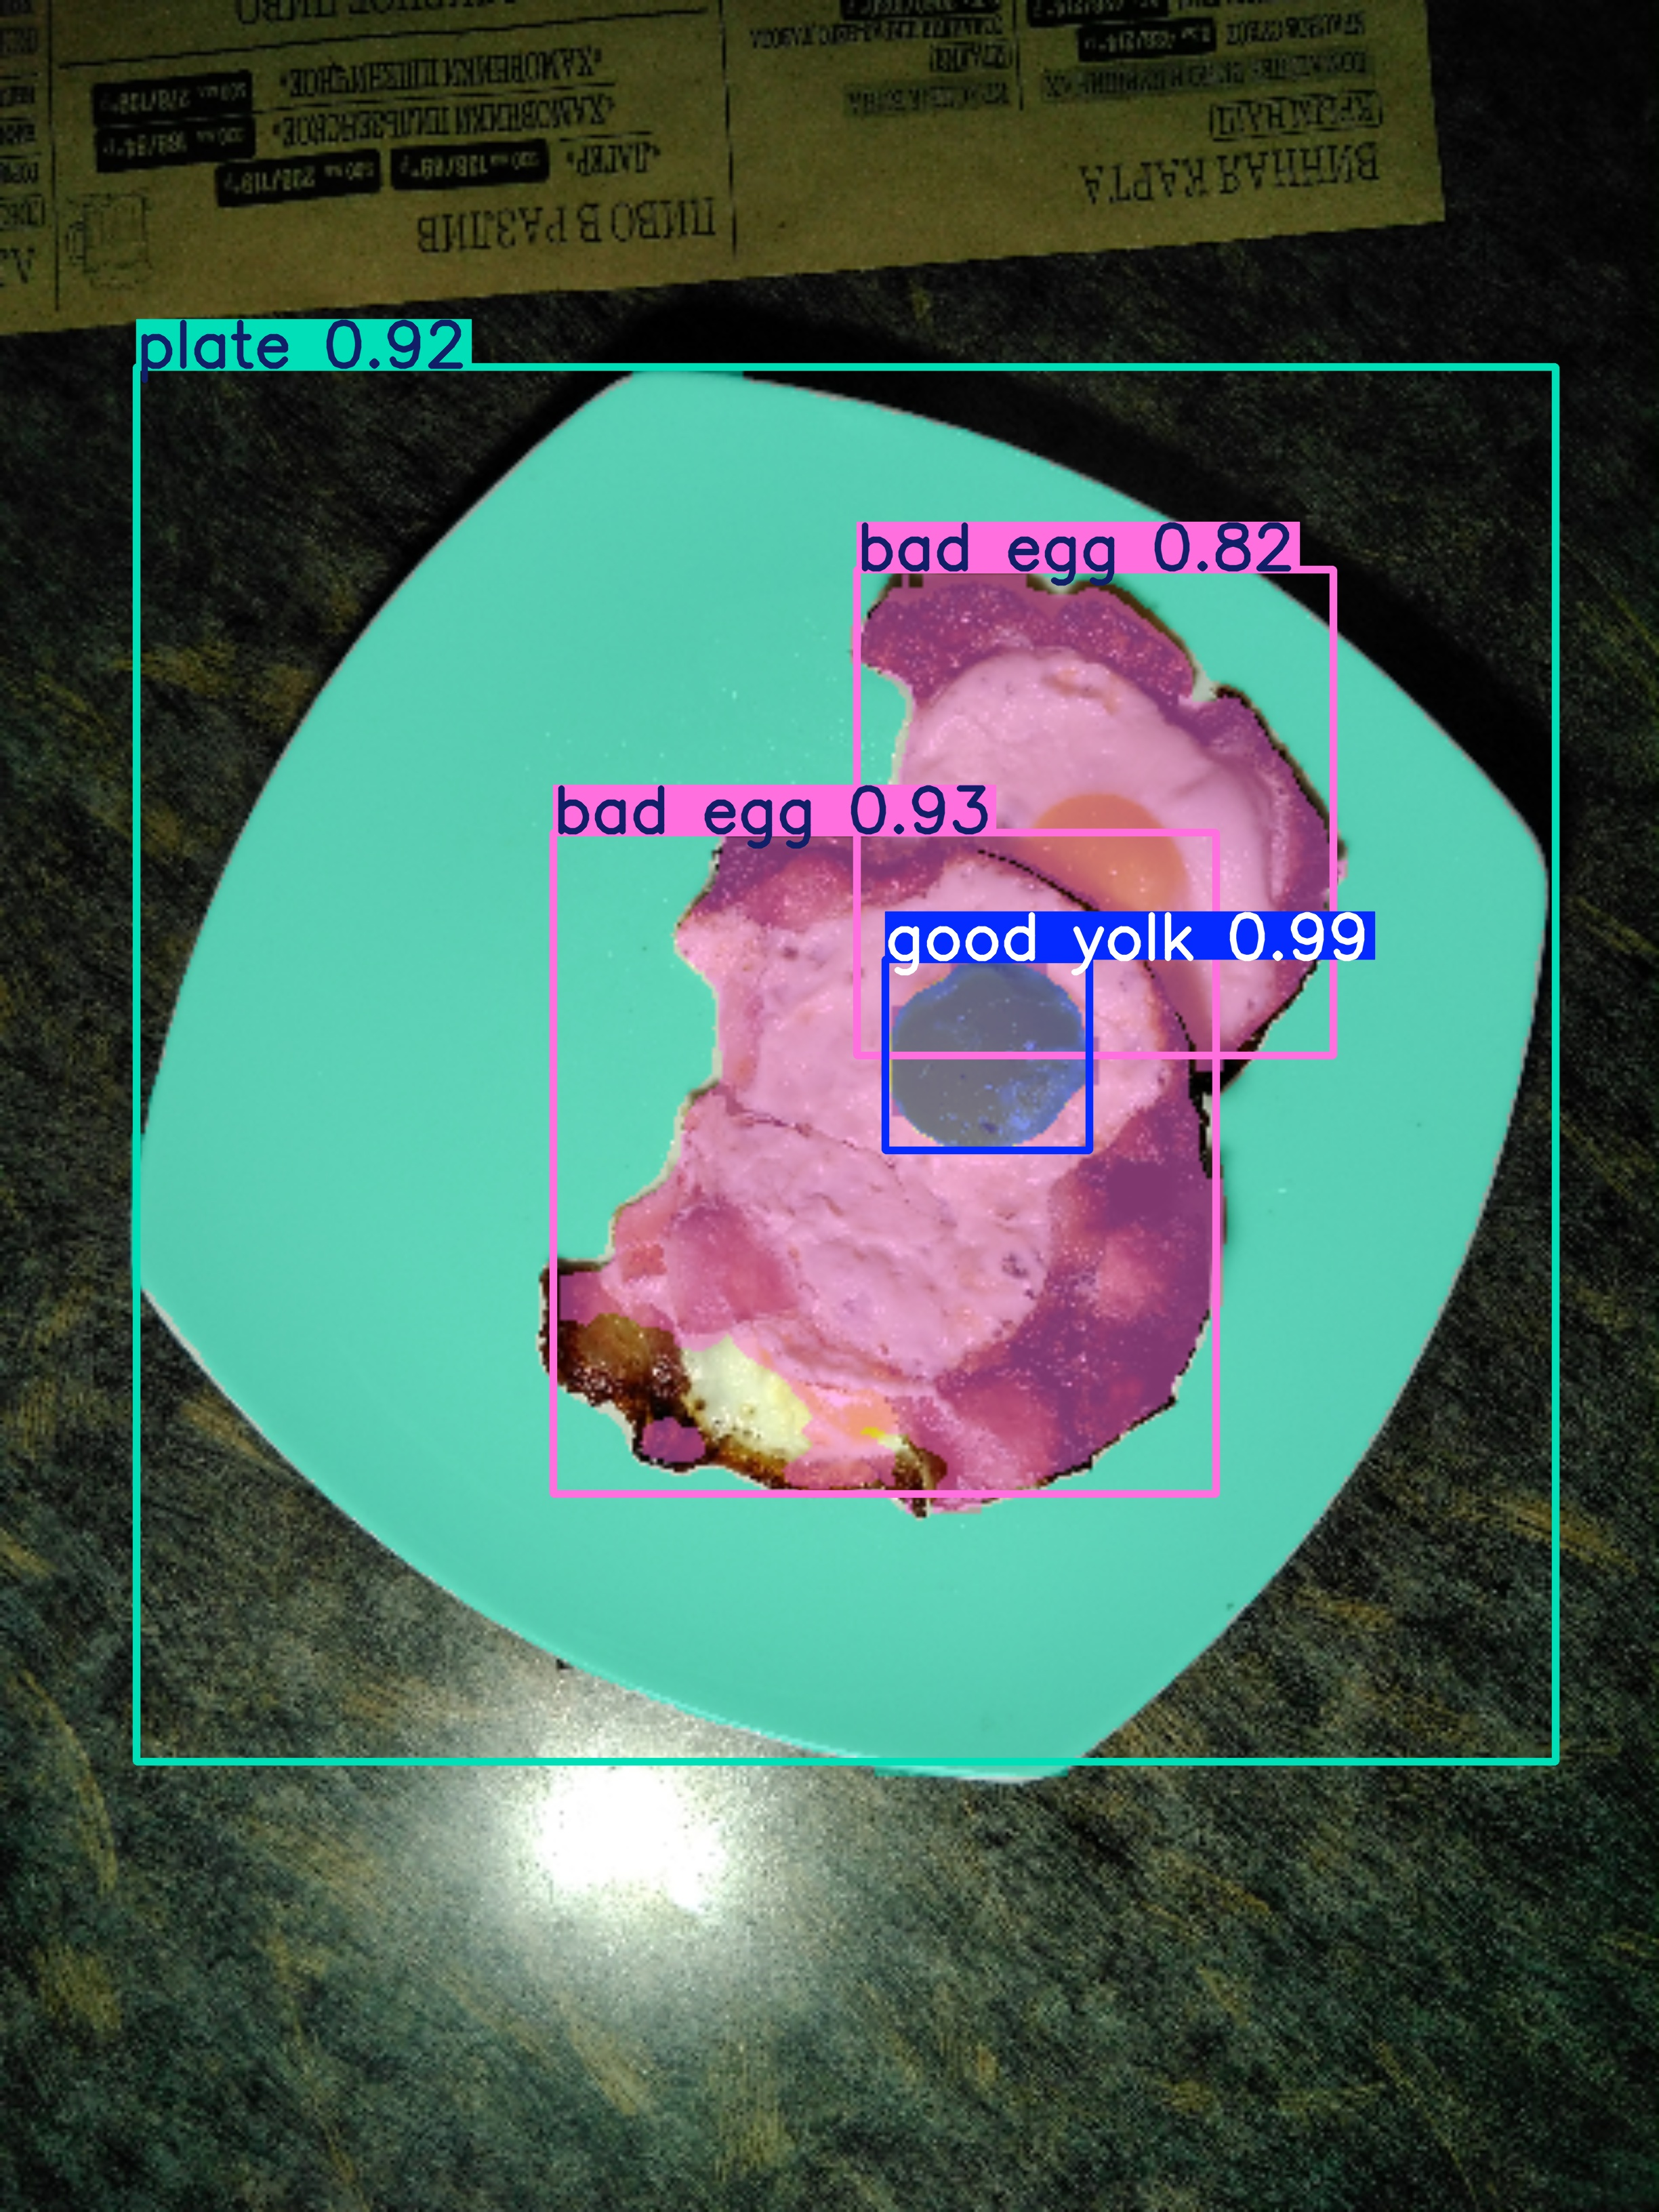

In [12]:
display(Image(filename=predicted_imgs[196]))

# Labeling Images:

• 0 – good fried eggs (three yolks, parsley in the center, well-cooked, looks like a
whole and not several separate pieces),

• 1 – overcooked or overturned fried eggs,

• 2 – fried eggs with two yolks,

• 3 – fried eggs with a broken yolk,

• 4 – fried eggs with four yolks,

• 5 – fried eggs with a wrong position of ingredients or they are missing, wrong
placement or composition, undercooked.


In [13]:
Image_labels = {
    0 : "good fried eggs",
    1 : "overcooked or overturned fried eggs",
    2 : "fried eggs with two yolks",
    3 : "fried eggs with a broken yolk",
    4 : "fried eggs with four yolks",
    5 : "fried eggs with a wrong position of ingredients or they are missing, wrong placement or composition, undercooked."
}

Img_labls_path = {}

- labeling cause it s already done!

In [14]:
Img_labls_path = {
    "IMG_20180213_172533": 3,
    "IMG_20180213_172557": 3,
    "IMG_20180213_172559": 3,
    "IMG_20180213_172603": 3,
    "IMG_20180213_172606": 3,
    "IMG_20180213_172620": 3,
    "IMG_20180213_172624": 3,
    "IMG_20180213_172631": 3,
    "IMG_20180213_172635": 3,
    "IMG_20180213_172638": 3,
    "IMG_20180213_172640": 3,
    "IMG_20180213_172648": 3,
    "IMG_20180213_172653": 3,
    "IMG_20180213_172719": 3,
    "IMG_20180213_172728": 3,
    "IMG_20180213_172731": 3,
    "IMG_20180213_172734": 3,
    "IMG_20180213_174956": 4,
    "IMG_20180213_175252": 4,
    "IMG_20180213_175301": 4,
    "IMG_20180213_175304": 4,
    "IMG_20180213_175309": 4,
    "IMG_20180213_175318": 4,
    "IMG_20180213_175323": 4,
    "IMG_20180213_175325": 4,
    "IMG_20180213_175510": 4,
    "IMG_20180213_175558": 4,
    "IMG_20180213_175600": 4,
    "IMG_20180213_175603": 4,
    "IMG_20180213_175615": 4,
    "IMG_20180213_175618": 4,
    "IMG_20180213_175620": 4,
    "IMG_20180213_175626": 4,
    "IMG_20180213_175629": 4,
    "IMG_20180213_175646": 2,
    "IMG_20180213_175649": 2,
    "IMG_20180213_175653": 2,
    "IMG_20180213_175655": 2,
    "IMG_20180213_175658": 2,
    "IMG_20180213_175703": 2,
    "IMG_20180213_175707": 2,
    "IMG_20180213_175710": 2,
    "IMG_20180213_175716": 2,
    "IMG_20180213_175722": 2,
    "IMG_20180213_175738": 2,
    "IMG_20180213_180044": 2,
    "IMG_20180213_180047": 2,
    "IMG_20180213_172742": 0,
    "IMG_20180213_172755": 0,
    "IMG_20180213_172758": 0,
    "IMG_20180213_172802": 0,
    "IMG_20180213_172808": 0,
    "IMG_20180213_172811": 0,
    "IMG_20180213_172813": 0,
    "IMG_20180213_172848": 0,
    "IMG_20180213_172850": 0,
    "IMG_20180213_172856": 0,
    "IMG_20180213_172905": 0,
    "IMG_20180213_174918": 0,
    "IMG_20180213_174927": 0,
    "IMG_20180213_174931": 0,
    "IMG_20180213_175243": 0,
    "IMG_20180213_175246": 0,
    "IMG_20180213_175250": 0,
    "IMG_20180213_175957": 0,
    "IMG_20180213_180052": 0,
    "IMG_20180213_180124": 0,
    "IMG_20180213_173024": 1,
    "IMG_20180213_173028": 1,
    "IMG_20180213_173037": 1,
    "IMG_20180213_173050": 1,
    "IMG_20180213_173053": 1,
    "IMG_20180213_173204": 1,
    "IMG_20180213_173206": 1,
    "IMG_20180213_173208": 1,
    "IMG_20180213_173211": 1,
    "IMG_20180213_173213": 1,
    "IMG_20180213_173648": 1,
    "IMG_20180213_173650": 1,
    "IMG_20180213_173653": 1,
    "IMG_20180213_173658": 1,
    "IMG_20180213_173705": 1,
    "IMG_20180213_173709": 1,
    "IMG_20180213_173711": 1,
    "IMG_20180213_173714": 1,
    "IMG_20180213_173716": 1,
    "IMG_20180213_173721": 1,
    "IMG_20180213_173724": 1,
    "IMG_20180213_173726": 1,
    "IMG_20180213_173736": 1,
    "IMG_20180213_173755": 1,
    "IMG_20180213_173758": 1,
    "IMG_20180213_173801": 1,
    "IMG_20180213_173804": 1,
    "IMG_20180213_173808": 1,
    "IMG_20180213_173812": 1,
    "IMG_20180213_173830": 1,
    "IMG_20180213_173833": 1,
    "IMG_20180213_173836": 1,
    "IMG_20180213_173838": 1,
    "IMG_20180213_173841": 1,
    "IMG_20180213_173843": 1,
    "IMG_20180213_174137": 1,
    "IMG_20180213_174312": 1,
    "IMG_20180213_174635": 1,
    "IMG_20180213_174647": 1,
    "IMG_20180213_174651": 1,
    "IMG_20180213_174654": 1,
    "IMG_20180213_174702": 1,
    "IMG_20180213_174708": 1,
    "IMG_20180213_174714": 1,
    "IMG_20180213_174721": 1,
    "IMG_20180213_174730": 1,
    "IMG_20180213_175002": 1,
    "IMG_20180213_175014": 1,
    "IMG_20180213_175019": 1,
    "IMG_20180213_175022": 1,
    "IMG_20180213_175027": 1,
    "IMG_20180213_175039": 1,
    "IMG_20180213_175415": 1,
    "IMG_20180213_175420": 1,
    "IMG_20180213_175423": 1,
    "IMG_20180213_175435": 1,
    "IMG_20180213_175442": 1,
    "IMG_20180213_175458": 1,
    "IMG_20180213_175502": 1,
    "IMG_20180213_175505": 1,
    "IMG_20180213_175931": 1,
    "IMG_20180213_175935": 1,
    "IMG_20180213_175938": 1,
    "IMG_20180213_175941": 1,
    "IMG_20180213_172433": 5,
    "IMG_20180213_172438": 5,
    "IMG_20180213_172441": 5,
    "IMG_20180213_172446": 5,
    "IMG_20180213_172448": 5,
    "IMG_20180213_172454": 5,
    "IMG_20180213_172501": 5,
    "IMG_20180213_172510": 5,
    "IMG_20180213_172512": 5,
    "IMG_20180213_172515": 5,
    "IMG_20180213_172517": 5,
    "IMG_20180213_172519": 5,
    "IMG_20180213_172522": 5,
    "IMG_20180213_172525": 5,
    "IMG_20180213_172527": 5,
    "IMG_20180213_175042": 5,
    "IMG_20180213_175102": 5,
    "IMG_20180213_175108": 5,
    "IMG_20180213_175111": 5,
    "IMG_20180213_175113": 5,
    "IMG_20180213_175154": 5,
    "IMG_20180213_175231": 5,
    "IMG_20180213_175238": 5,
    "IMG_20180213_175240": 5,
    "IMG_20180213_175343": 5,
    "IMG_20180213_175418": 5,
    "IMG_20180213_175856": 5,
    "IMG_20180213_175906": 5,
    "IMG_20180213_175908": 5,
    "IMG_20180213_180027": 5,
    "IMG_20180213_180119": 5,
    "IMG_20180213_172805": 0,
    "IMG_20180213_172926": 0,
    "IMG_20180213_174912": 0,
    "IMG_20180213_174915": 0,
    "IMG_20180213_175759": 0,
    "IMG_20180213_175832": 0,
    "IMG_20180213_175839": 0,
    "IMG_20180213_175852": 0,
    "IMG_20180213_175944": 0,
    "IMG_20180213_175951": 0,
    "IMG_20180213_175954": 0,
    "IMG_20180213_180001": 0,
    "IMG_20180213_180004": 0,
    "IMG_20180213_180008": 0,
    "IMG_20180213_180010": 0,
    "IMG_20180213_180017": 0,
    "IMG_20180213_180021": 0,
    "IMG_20180213_172933": 5,
    "IMG_20180213_172935": 5,
    "IMG_20180213_172947": 5,
    "IMG_20180213_172953": 1,
    "IMG_20180213_173001": 1,
    "IMG_20180213_173007": 1,
    "IMG_20180213_173011": 1,
    "IMG_20180213_173021": 1,
    "IMG_20180213_173043": 1,
    "IMG_20180213_173047": 1,
    "IMG_20180213_174940": 0,
    "IMG_20180213_174946": 0,
    "IMG_20180213_174951": 0,
    "IMG_20180213_175126": 0,
    "IMG_20180213_175137": 0,
    "IMG_20180213_175202": 5,
    "IMG_20180213_175227": 0,
    "IMG_20180213_175236": 5,
    "IMG_20180213_180013": 0,
    "IMG_20180213_180105": 0
}

In [15]:
def validate_image_label(label_key, img_path):
    GREEN = "\033[92m"
    RESET = "\033[0m"
    print(f'This image is related to the label: {GREEN}{Image_labels[label_key]}{RESET}')

    key = input("Press '1' To confirme, or anything else to pass")
    if key == '1':
        image_name = str(img_path)[str(img_path).rfind("/")+1:-4]
        Img_labls_path[image_name] = label_key
        print(f"{GREEN}Saved{RESET}")

In [16]:
from collections import Counter
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

def label_semi_manual(label_key, func):
    if len(Img_labls_path) == len(os.listdir(os.path.join(Source_images_path, "train"))):
        print("All Images are already Labeled!")
        return
    for result in results:
        clear_output(wait=True)
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        counts = Counter(class_ids)
        names = model.names
    
        # summary = ', '.join(f"{counts[c]} {names[c]}" for c in counts)
        # print(summary)
        GREEN = "\033[92m"
        RESET = "\033[0m"
        image_name = str(result.path)[str(result.path).rfind("/")+1:-4]
        if Img_labls_path.get(image_name, "") != "":
            print(f"{GREEN}{Image_labels[Img_labls_path[image_name]]}{RESET}")

        elif func(counts): #counts.get(1, 0) > 0:
            original = cv2.imread(result.path)
            original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            pred_image = result.plot()
            pred_image_rgb = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)

            # Display side-by-side
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(original_rgb)
            plt.title("Original Image")
            plt.axis("off")
            
            plt.subplot(1, 2, 2)
            plt.imshow(pred_image_rgb)
            plt.title("YOLO Predictions")
            plt.axis("off")
            
            plt.tight_layout()
            plt.show()
    
            validate_image_label(label_key, result.path)

## Checking for BrokenYolk:

In [17]:
def brokenYolk(counts):
    if counts.get(1, 0) > 0:
        return True
    return False

label_semi_manual(3, brokenYolk)

All Images are already Labeled!


## Checking for 4yolks:

In [18]:
def FoorYolk(counts):
    if counts.get(0, 0) > 3:
        return True
    return False

label_semi_manual(4, FoorYolk)

All Images are already Labeled!


## Checking for 2yolks:

In [19]:
def TwoYolk(counts):
    if counts.get(0, 0) < 3:
        return True
    return False

label_semi_manual(2, TwoYolk)

All Images are already Labeled!


## Checking overcooked or overturned fried eggs

In [20]:
def overcooked_overturned(counts):
    if counts.get(5, 0) > 0:
        return True
    return False

label_semi_manual(1, overcooked_overturned)

All Images are already Labeled!


## Checking undercooked fried eggs

In [21]:
def undercooked(counts):
    if counts.get(5, 0) > 0:
        return True
    return False

label_semi_manual(5, undercooked)

All Images are already Labeled!


## Checking Good Fried Eggs

In [22]:
def good_fried_eggs(counts):
    if counts.get(0, 0) == 3 and counts.get(2, 0) > 0:
        return True
    return False

label_semi_manual(0, good_fried_eggs)

All Images are already Labeled!


## Checking labels for the rest of the imgs

In [23]:
def validate_image_label_v2(img_path):
    print(Image_labels)

    key = input("Choose one of the labels: ")
    count = 0
    while int(key) not in list(Image_labels.keys()):
        count += 1
        key = input("Choose one of the labels: ")
        if count == 10:
            raise Exception("Wa 3y9tii")

    image_name = str(img_path)[str(img_path).rfind("/")+1:-4]
    Img_labls_path[image_name] = int(key)
    print(f"{GREEN}Saved{RESET}")

if len(Img_labls_path) == len(os.listdir(os.path.join(Source_images_path, "train"))):
    print("All Images are already Labeled!")
else:
    for result in results:
        clear_output(wait=True)
        GREEN = "\033[92m"
        RESET = "\033[0m"
        image_name = str(result.path)[str(result.path).rfind("/")+1:-4]
        if Img_labls_path.get(image_name, "") != "":
            print(f"{GREEN}{Image_labels[Img_labls_path[image_name]]}{RESET}")
        else:
            class_ids = result.boxes.cls.cpu().numpy().astype(int)
            counts = Counter(class_ids)
            names = model.names
            original = cv2.imread(result.path)
            original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            pred_image = result.plot()
            pred_image_rgb = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
        
            # Display side-by-side
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(original_rgb)
            plt.title("Original Image")
            plt.axis("off")
            
            plt.subplot(1, 2, 2)
            plt.imshow(pred_image_rgb)
            plt.title("YOLO Predictions")
            plt.axis("off")
            
            plt.tight_layout()
            plt.show()
    
            validate_image_label_v2(result.path)

All Images are already Labeled!


In [24]:
import os, json

with open(os.path.join(Saving_path, "labels.json"), "w") as f:
    json.dump(Img_labls_path, f, indent=4)

In [25]:
len(Img_labls_path)

199

# Preprocessing Images

## Resizing and Croping Images

In [26]:
from IPython.display import display, clear_output

def display_image(img_rgb, display_out, coords_results):
    clear_output(wait=True)
    x1, y1, x2, y2 = coords_results
    img_crop = img_rgb[y1:y2, x1:x2]
    plt.figure(figsize=(6, 4))
    plt.imshow(img_crop)
    plt.axis('off')
    plt.title("Current Crop Preview")
    plt.show()


In [27]:
def crop_manual(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    display_out = widgets.Output()
    coords_results = [0, 0, width, height]

    for key, coord in enumerate(coords_results.copy()):
        coord_res = 0
        while coord_res != -1:
            display_image(img_rgb, display_out, coords_results)
            try:
                coord_res = int(input(f"Enter the `{'x' if key%2==0 else 'y'}` if the image is good Press -1, The Number should be between [0, {width if key%2==0 else height}], current value = {coords_results[key]}"))
            except ValueError:
                continue
            if coord_res != -1:
                coords_results[key] = coord_res

    return coords_results


In [28]:
import cv2
import numpy as np

def get_mask_image(result, class_names, class_name, h, w):
    class_mask = np.zeros((h, w), dtype=np.uint8)
    masks = result.masks.data
    for i, class_id in enumerate(result.boxes.cls):
        if class_names[int(class_id)] == class_name:
            mask = masks[i].cpu().numpy()
            resized_mask = cv2.resize(mask, (w, h))
            class_mask[resized_mask.astype(bool)] = 255
    return class_mask

In [29]:
import cv2
manual_crop_coord = {}
manual_crop_coord = {
    'IMG_20180213_173650': (270, 290, 2448, 2450),
    'IMG_20180213_173711': (280, 600, 2270, 2550),
    'IMG_20180213_173714': (300, 500, 2400, 2600),
    'IMG_20180213_173716': (300, 500, 2400, 2600),
    'IMG_20180213_173801': (180, 430, 2340, 2600),
    'IMG_20180213_173838': (120, 340, 2350, 2570),
    'IMG_20180213_173843': (200, 230, 2400, 2420),
    'IMG_20180213_174137': (360, 720, 2380, 2700),
    'IMG_20180213_174654': (300, 880, 2180, 2730),
    'IMG_20180213_174702': (370, 820, 2180, 2620),
    'IMG_20180213_174714': (320, 820, 2100, 2600),
    'IMG_20180213_175240': (320, 1150, 2150, 2950)
}


images_path = os.path.join(Saving_path, "crop/images")
mask_path = os.path.join(Saving_path, "crop/masks")

if not os.path.exists(images_path):
    os.makedirs(images_path, exist_ok=False)
if not os.path.exists(mask_path):
    os.makedirs(mask_path, exist_ok=False)

for result in results:
    names = model.names
    boxes = result.boxes

    boxes_idx = []
    for i in range(len(boxes)):
        cls_id = int(boxes.cls[i])
        if names[cls_id] == "plate":
            boxes_idx.append(i)

    manual_crop = False
    if len(boxes_idx) == 1:
        i = boxes_idx[0]
    elif len(boxes_idx) == 0:
        print(f"No plate Found in {str(result.path)} ==> Going Manual")
        image_name = str(result.path)[str(result.path).rfind("/")+1:-4]
        if manual_crop_coord.get(image_name, "") == "":
            x1, y1, x2, y2 = crop_manual(str(result.path))
            manual_crop_coord[image_name] = x1, y1, x2, y2
            manual_crop = True
        else:
            print("Coords are already assigned manually")
            x1, y1, x2, y2 = manual_crop_coord[image_name]
    else:
        best_idx = boxes_idx[0]
        for i in boxes_idx:
            if boxes.conf[i].item() > boxes.conf[best_idx].item():
                best_idx = boxes.conf[i].item()
        i = best_idx

    img_name = str(result.path)[str(result.path).rfind("/")+1:-4]

    img = cv2.imread(str(result.path))
    if not manual_crop:
        xyxy = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy

    crop_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(crop_img, (1024, 768))

    cv2.imwrite(f"{images_path}/{img_name}.jpg", resized_img)

    for class_name in names.values():
        height, width = img.shape[:2]
        mask_img = get_mask_image(result, names, class_name, height, width)
        crop_mask = mask_img[y1:y2, x1:x2]
        resized_mask = cv2.resize(crop_mask, (1024, 768))

        cv2.imwrite(f"{mask_path}/mask_{class_name}_{img_name}.jpg", resized_mask)

No plate Found in /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_173650.jpg ==> Going Manual
Coords are already assigned manually
No plate Found in /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_173711.jpg ==> Going Manual
Coords are already assigned manually
No plate Found in /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_173714.jpg ==> Going Manual
Coords are already assigned manually
No plate Found in /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_173716.jpg ==> Going Manual
Coords are already assigned manually
No plate Found in /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_173801.jpg ==> Going Manual
Coords are already assigned manually
No plate Found in /kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/train/IMG_20180213_173838.jpg ==> Going Manual
Coords are already assigned manually
No plate Found in /kaggle/input/fried-eggs/P07

# Classification of the images

In [30]:
%%capture

!pip install timm

## Prepare DataSet

In [31]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import torch
import os

class MultiMaskDataset(Dataset):
    def __init__(self, root_dir, labels, img_labels, mask_classes, transform=None):
        self.samples = []
        self.classes = labels
        self.mask_classes = mask_classes
        self.transform = transform or T.Compose([T.Resize((224, 224)),T.ToTensor()])
        images_path = os.path.join(root_dir, "images")
        masks_path = os.path.join(root_dir, "masks")
        if not os.path.exists(images_path) or not os.path.exists(masks_path):
            raise ValueError(f"{root_dir} doesn t have images folder or masks folder!")

        for image in os.listdir(images_path):
            image_name = image[:image.rfind(".")]
            data = {}
            data["image_path"] = os.path.join(images_path, image)
            data["mask_paths"] = {}
            for class_name in mask_classes.values():
                mask_path = os.path.join(masks_path, f"mask_{class_name}_{image_name}.jpg")
                if not os.path.exists(mask_path):
                    raise ValueError(f"{class_name} mask does not exists for the image: {image_name}")
                data["mask_paths"][class_name] = mask_path
            data["label"] = img_labels[image_name]
            self.samples.append(data)

    def preprocess(self, sample):
        image_path = sample['image_path']
        mask_paths = sample['mask_paths']

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        mask_channels = []
        for mclass in self.mask_classes.values():
            mask_path = mask_paths[mclass]
            mask = Image.open(mask_path).convert('L')
            mask = self.transform(mask)
            mask_bin = (mask > 0.5).float()
            mask_channels.append(mask_bin)

        multi_mask = torch.cat(mask_channels, dim=0)

        x = torch.cat([image, multi_mask], dim=0)

        return x

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = sample['label']

        return self.preprocess(sample), label

    def __len__(self):
        return len(self.samples)


## Training func

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

# Train ResNet model

In [33]:
from torch.utils.data import random_split

dataset = MultiMaskDataset(root_dir = os.path.join(Saving_path, "crop"),
                          labels = Image_labels,
                          img_labels = Img_labls_path,
                          mask_classes = model.names)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# Model
print("Using GPU" if torch.cuda.is_available() else "Using CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Res_model = timm.create_model("resnet18", pretrained=True, in_chans=3+len(dataset.mask_classes), num_classes=len(dataset.classes))
Res_model.to(device)

# Optimizer + loss
optimizer = torch.optim.Adam(Res_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(30):
    loss, acc = train(Res_model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}: Loss={loss:.4f} Acc={acc:.4f}")

Using GPU


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 1: Loss=1.7881 Acc=0.1950


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 2: Loss=1.6788 Acc=0.4969


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 3: Loss=1.5824 Acc=0.6164


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 4: Loss=1.4905 Acc=0.6101


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 5: Loss=1.4024 Acc=0.6101


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 6: Loss=1.2943 Acc=0.6164


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch 7: Loss=1.2284 Acc=0.6226


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 8: Loss=1.1532 Acc=0.6164


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 9: Loss=1.0659 Acc=0.6792


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 10: Loss=0.9978 Acc=0.7233


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 11: Loss=0.9390 Acc=0.7296


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch 12: Loss=0.8941 Acc=0.7736


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 13: Loss=0.7936 Acc=0.7987


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 14: Loss=0.7640 Acc=0.8239


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 15: Loss=0.7088 Acc=0.8302


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 16: Loss=0.6919 Acc=0.8553


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 17: Loss=0.6254 Acc=0.8742


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 18: Loss=0.6009 Acc=0.9057


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 19: Loss=0.5406 Acc=0.9119


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 20: Loss=0.5001 Acc=0.9308


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 21: Loss=0.4359 Acc=0.9686


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch 22: Loss=0.4315 Acc=0.9497


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 23: Loss=0.3903 Acc=0.9623


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch 24: Loss=0.3571 Acc=0.9937


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 25: Loss=0.3330 Acc=0.9811


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 26: Loss=0.3302 Acc=0.9937


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 27: Loss=0.2966 Acc=0.9874


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch 28: Loss=0.2268 Acc=1.0000


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 29: Loss=0.2528 Acc=0.9937


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

Epoch 30: Loss=0.2116 Acc=1.0000


# Prediction

In [34]:
import os, cv2

def  prepare_masks_for_pred(pred_imgs_path, Yolo_model):
    masks_path = os.path.join(pred_imgs_path, "masks")
    if not os.path.exists(masks_path):
        os.makedirs(masks_path, exist_ok=False)
    results = Yolo_model.predict(source=os.path.join(pred_imgs_path, "images"), save=False)
    for result in results:
        img = cv2.imread(str(result.path))
        for class_name in names.values():
            height, width = img.shape[:2]
            mask_img = get_mask_image(result, names, class_name, height, width)
            img_name = str(result.path)[str(result.path).rfind("/")+1:-4]
            cv2.imwrite(f"{masks_path}/mask_{class_name}_{img_name}.jpg", mask_img)


In [35]:
import os
from PIL import Image


def copy_imgs(images_path, dst_path):
    if os.path.exists(dst_path):
        shutil.rmtree(dst_path)
    os.makedirs(dst_path, exist_ok=False)
    for image_path in os.listdir(images_path):
        shutil.copy(os.path.join(images_path, image_path), dst_path)

def predict_images(images_path, dataset, Res_model, Yolo_model, working_dir="/kaggle/working"):
    pred_imgs_path = os.path.join(working_dir, "img_predictions")
    if not os.path.exists(pred_imgs_path):
        os.makedirs(pred_imgs_path, exist_ok=False)
    copy_imgs(images_path, os.path.join(pred_imgs_path, "images"))
    prepare_masks_for_pred(pred_imgs_path, Yolo_model)

    predictions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Res_model.to(device)
    Res_model.eval()

    for image_name in os.listdir(os.path.join(pred_imgs_path, "images")):
        data = {}
        data["img"] = image_name[:image_name.rfind(".")]
        sample = {}
        sample["image_path"] = os.path.join(pred_imgs_path, f"images/{image_name}")
        sample['mask_paths'] = {}
        for class_name in dataset.mask_classes.values():
            sample['mask_paths'][class_name] = os.path.join(pred_imgs_path, f"masks/mask_{class_name}_{image_name}")

        preprocessed_image = dataset.preprocess(sample).unsqueeze(0).to(device)
        with torch.no_grad():
            output = Res_model(preprocessed_image)
            pred_idx = torch.argmax(output, dim=1).item()
            data["label"] = dataset.classes[pred_idx]

        predictions.append(data)

    return predictions

predictions = predict_images("/kaggle/input/fried-eggs/P07. Fried eggs/P07. Fried eggs/test",
              dataset, Res_model, model)


image 1/65 /kaggle/working/img_predictions/images/IMG_20180213_172431.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 3 bacons, 3 bad eggs, 11.3ms
image 2/65 /kaggle/working/img_predictions/images/IMG_20180213_172436.jpg: 640x480 3 good yolks, 1 permesion, 1 plate, 4 bacons, 3 bad eggs, 10.4ms
image 3/65 /kaggle/working/img_predictions/images/IMG_20180213_172456.jpg: 640x480 2 good yolks, 1 permesion, 1 plate, 2 bacons, 2 bad eggs, 9.8ms
image 4/65 /kaggle/working/img_predictions/images/IMG_20180213_172615.jpg: 640x480 3 good yolks, 1 broken yolk, 1 permesion, 1 plate, 5 bacons, 3 bad eggs, 9.7ms
image 5/65 /kaggle/working/img_predictions/images/IMG_20180213_172618.jpg: 640x480 2 good yolks, 1 broken yolk, 1 permesion, 1 plate, 3 bacons, 2 bad eggs, 9.8ms
image 6/65 /kaggle/working/img_predictions/images/IMG_20180213_172651.jpg: 640x480 2 good yolks, 1 broken yolk, 1 permesion, 1 plate, 3 bacons, 2 bad eggs, 9.8ms
image 7/65 /kaggle/working/img_predictions/images/IMG_20180213_172722.

In [36]:
import csv

with open(f'{Saving_path}/predictions.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["img", "label"])
    writer.writeheader()
    writer.writerows(predictions)

In [37]:
!cat /kaggle/working/predictions.csv